# **TOPIC:** Replicating plots for Nathan's presentation 

## **Author:** JM
## **Date:** 05-15-2025
### **Notes**: URL https://www.dropbox.com/scl/fi/5krjj8i0nu02aak1fmbsg/Mismatch-Slides-40-mins-Melbourne-Public-Lecture.pdf?rlkey=5kc8hgn13ab7i7ox7zmtfpkqu&dl=0

In [5]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import mapclassify
from matplotlib.patches import Patch
from pathlib import Path
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties

## - Setting paths and importing shapes

In [6]:
# Set base project path
base_path = Path("C:/Users/juami/Dropbox/RAships/2-Folklore-Nathan-Project/EA-Maps-Nathan-project/Measures_work")

# Set file paths
precol_path = base_path / "maps" / "interim" / "pre_columbian_update" / "world_thiessen_UPDATE" / "EAESW_XY_World_Thiessen_MurdockUpdate_EAinfo.gpkg"
poscol_path = base_path / "data" / "raw" / "ethnologue" / "ancestral_characteristics_database_language_level" / "Ethnologue_16_shapefile" / "langa_no_overlap_biggest_clean.shp"

basemap_path = base_path / "maps" / "interim" / "World" / "world_dissolve_nolakes.shp"

data_path = base_path / "data" / "interim"

export_path = base_path / "deliveries" / "maps_presentation_12052025"

In [7]:
# Read the shapefiles and CSV files
precol_shape = gpd.read_file(precol_path)
poscol_shape = gpd.read_file(poscol_path)
basemap_shape = gpd.read_file(basemap_path)

In [8]:
print(precol_shape.crs)
print(poscol_shape.crs) 
print(basemap_shape.crs)

EPSG:4326
EPSG:4326
EPSG:4326


### Fixing Pre-Columbian shape

In [9]:
# Fixing the high gods variable
highGods_fillin_df = pd.read_csv(data_path / "high_gods_fillin_thiessen.csv")
precol_shape = precol_shape.merge(highGods_fillin_df, left_on='v107', right_on='v107', how='left')

precol_shape['v34_fill'] = precol_shape['v34_fill'].replace(0, np.nan)
precol_shape['v34'] = precol_shape['v34'].replace(0, np.nan)
precol_shape['v66'] = precol_shape['v66'].replace(0, np.nan)

In [10]:
#Fixing ancestor variable
ancestor_df = pd.read_csv(data_path / "EA_folklore_ancestor_sh.csv")
precol_shape = precol_shape.merge(ancestor_df, left_on='v107', right_on='v107', how='left')

### Fixing Pos-Columbian shape

In [11]:
# Fixing the variables to shape
folk_poscol_df = pd.read_csv(data_path / "Motifs_EA_WESEE_Ethnologue_humanvsnature_all.csv", encoding='latin1')

poscol_shape = poscol_shape.merge(folk_poscol_df, left_on='ID', right_on='id', how='left')

poscol_shape['v34'] = poscol_shape['v34'].replace(0, np.nan)
poscol_shape['v66'] = poscol_shape['v66'].replace(0, np.nan)
                           

## - Replicating the maps

In [12]:
# Setting the color palette for all the maps
def truncate_colormap(cmap_name='BuPu', minval=0.3, maxval=1.0, n=100):
    cmap = plt.get_cmap(cmap_name)
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        f'{cmap_name}_trunc', cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# Create a stronger BuPu (skip the lightest 30%)
strong_bupu = truncate_colormap('BuPu', 0.3, 1.0)

### -- Map 1: High Gods

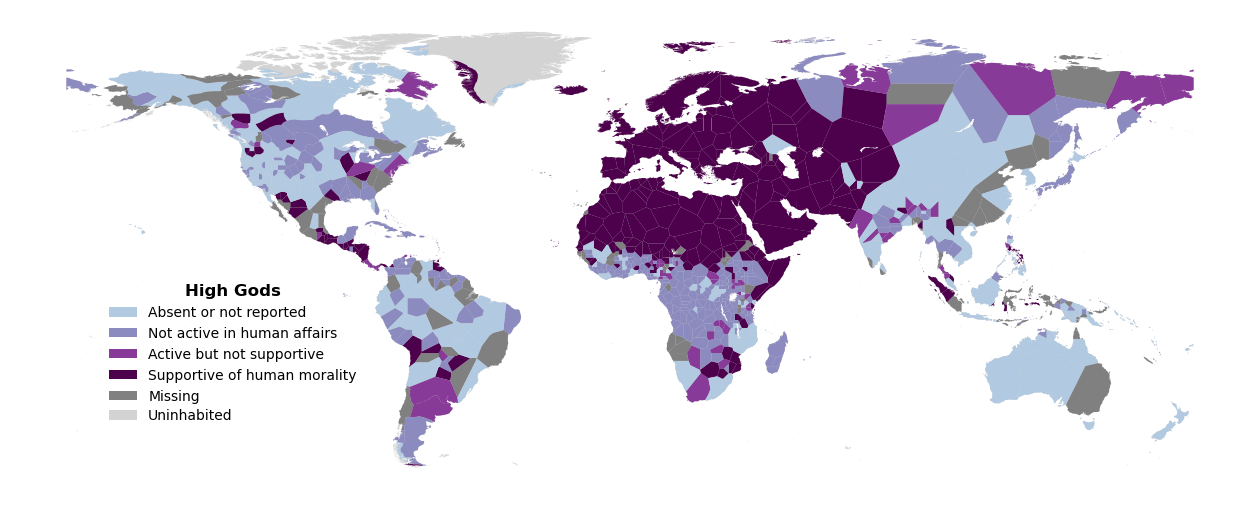

In [13]:
# Step 1: Extract unique categories (excluding NaNs)
categories = precol_shape['v34'].dropna().unique()
categories = sorted(categories)  # Optional: sort for consistent coloring

# Step 2: Sample colors from the custom colormap
n = len(categories)
category_colors = strong_bupu(np.linspace(0, 1, n))
category_color_map = dict(zip(categories, category_colors))

# Step 3: Map the colors to a new column
precol_shape['color'] = precol_shape['v34'].map(category_color_map)

# Step 4: Plot
fig, ax = plt.subplots(1, 1, figsize=(16, 8), facecolor='white')

# Background
basemap_shape.plot(
    ax=ax,
    color='lightgray',
    edgecolor='black',
    linewidth=0
)

# Plot polygons with mapped colors
precol_shape.plot(
    ax=ax,
    color=precol_shape['color'].fillna('gray'),  # gray for NaNs
    edgecolor='none',
    linewidth=0
)

# Dictionary for labels
label_map = {
    1: "Absent or not reported",
    2: "Not active in human affairs",
    3: "Active but not supportive",
    4: "Supportive of human morality"
}

# Custom legend
legend_elements = [
    Patch(facecolor=category_color_map[c], label=label_map.get(c, str(c)))
    for c in categories
]

# Add missing/NaN explicitly if you want
legend_elements.append(Patch(facecolor='gray', label="Missing"))

# Show legend on the map
legend = ax.legend(
    handles=legend_elements,
    loc='lower left',
    bbox_to_anchor=(0.07, 0.17, 0.2, 0.2),
    frameon=False,
    title="High Gods",
    title_fontproperties=FontProperties(weight='bold', size=12),
    prop=FontProperties(size=10)
)

# Create a rectangular legend patch
uninhabited_patch = Patch(
    facecolor='lightgray',
    edgecolor='none',
    label='Uninhabited'
)

# Add to the legend
custom_legend = ax.legend(
    handles=[uninhabited_patch],
    loc='lower left',
    bbox_to_anchor=(0.07, 0.13, 0.2, 0.2),
    frameon=False,
    prop = FontProperties(size=10),
)

#Add it to other legend
ax.add_artist(legend)

# Force same spatial extent
ax.set_aspect('equal', adjustable='box')
ax.set_axis_off()

# Save to PDF
plt.savefig(export_path / "Replication_HighGods_PRECOL.pdf", format='pdf', dpi=300, bbox_inches='tight')

#Show the plot
plt.show()

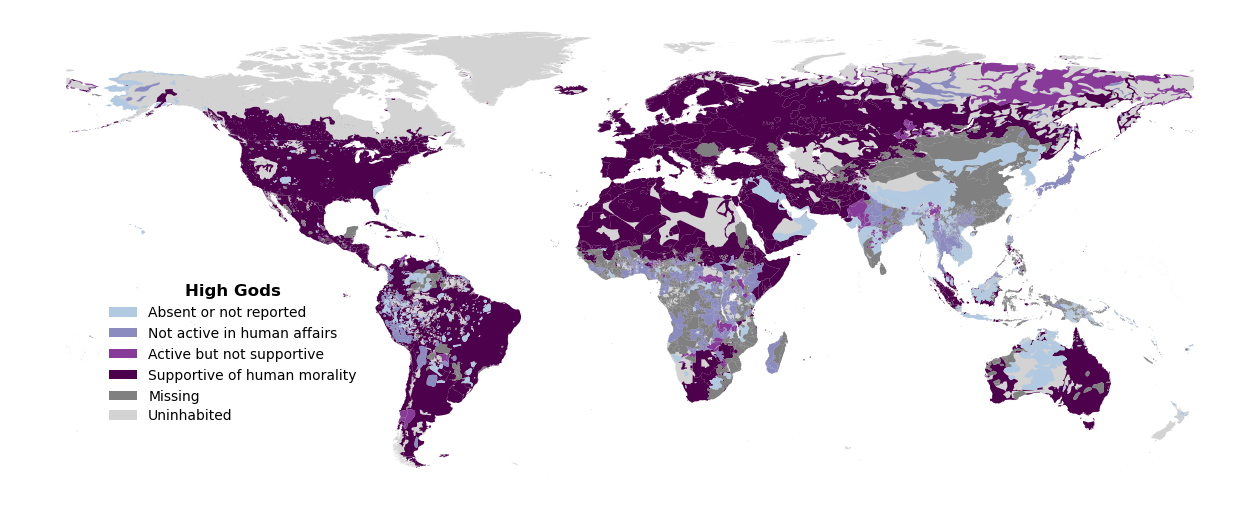

In [14]:
# Step 1: Extract unique categories (excluding NaNs)
categories = poscol_shape['v34'].dropna().unique()
categories = sorted(categories)  # Optional: sort for consistent coloring

# Step 2: Sample colors from the custom colormap
n = len(categories)
category_colors = strong_bupu(np.linspace(0, 1, n))
category_color_map = dict(zip(categories, category_colors))

# Step 3: Map the colors to a new column
poscol_shape['color'] = poscol_shape['v34'].map(category_color_map)

# Step 4: Plot
fig, ax = plt.subplots(1, 1, figsize=(16, 8), facecolor='white')

# Background
basemap_shape.plot(
    ax=ax,
    color='lightgray',
    edgecolor='black',
    linewidth=0
)

# Plot polygons with mapped colors
poscol_shape.plot(
    ax=ax,
    color=poscol_shape['color'].fillna('gray'),  # gray for NaNs
    edgecolor='none',
    linewidth=0
)

# Dictionary for labels
label_map = {
    1: "Absent or not reported",
    2: "Not active in human affairs",
    3: "Active but not supportive",
    4: "Supportive of human morality"
}

# Custom legend
legend_elements = [
    Patch(facecolor=category_color_map[c], label=label_map.get(c, str(c)))
    for c in categories
]

# Add missing/NaN explicitly if you want
legend_elements.append(Patch(facecolor='gray', label="Missing"))

# Show legend on the map
legend = ax.legend(
    handles=legend_elements,
    loc='lower left',
    bbox_to_anchor=(0.07, 0.17, 0.2, 0.2),
    frameon=False,
    title="High Gods",
    title_fontproperties=FontProperties(weight='bold', size=12),
    prop=FontProperties(size=10)
)

# Create a rectangular legend patch
uninhabited_patch = Patch(
    facecolor='lightgray',
    edgecolor='none',
    label='Uninhabited'
)

# Add to the legend
custom_legend = ax.legend(
    handles=[uninhabited_patch],
    loc='lower left',
    bbox_to_anchor=(0.07, 0.13, 0.2, 0.2),
    frameon=False,
    prop = FontProperties(size=10),
)

# Add it to other legend
ax.add_artist(legend)

# Force same spatial extent
ax.set_aspect('equal', adjustable='box')
ax.set_axis_off()

# Save to PDF
plt.savefig(export_path / "Replication_HighGods_POSCOL.pdf", format='pdf', dpi=300, bbox_inches='tight')

#Show the plot
plt.show()

### -- Map 2: Ancestors

In [15]:
# Define the number of quantiles
num_quantiles = 5

# Create quantile bins and get the labels
precol_shape['quantile_cat'], bins = pd.qcut(precol_shape['ancestor_sh'], q=num_quantiles, retbins=True, labels=False, duplicates='drop')

# Classifying with same bins
poscol_shape['quantile_cat'] = pd.cut(
    poscol_shape['ancestor_sh'],
    bins=bins,
    labels=False,
    include_lowest=True
)

#Creating the labels for the legend
label_map = {
    i: f"{bins[i]:.2f} - {bins[i+1]:.2f}"
    for i in range(len(bins) - 1)
}

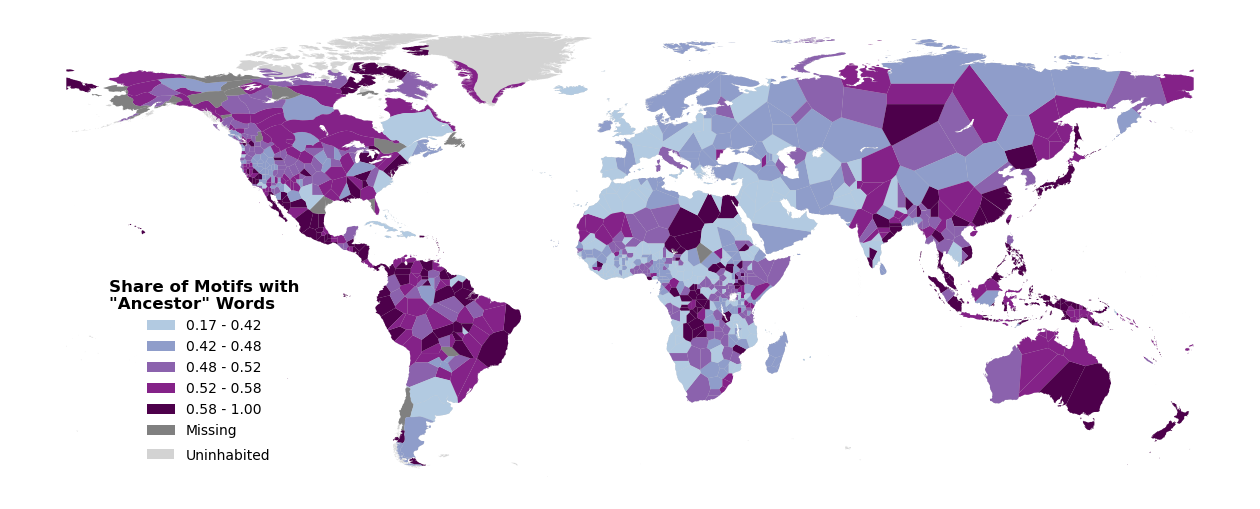

In [16]:
# Step 1: Extract unique categories (excluding NaNs)
categories = precol_shape['quantile_cat'].dropna().unique()
categories = sorted(categories)  # Optional: sort for consistent coloring

# Step 2: Sample colors from the custom colormap
n = len(categories)
category_colors = strong_bupu(np.linspace(0, 1, n))
category_color_map = dict(zip(categories, category_colors))

# Step 3: Map the colors to a new column
precol_shape['color'] = precol_shape['quantile_cat'].map(category_color_map)

# Step 4: Plot
fig, ax = plt.subplots(1, 1, figsize=(16, 8), facecolor='white')

# Background
basemap_shape.plot(
    ax=ax,
    color='lightgray',
    edgecolor='black',
    linewidth=0
)

# Plot polygons with mapped colors
precol_shape.plot(
    ax=ax,
    color=precol_shape['color'].fillna('gray'),  # gray for NaNs
    edgecolor='none',
    linewidth=0
)

# Custom legend
legend_elements = [
    Patch(facecolor=category_color_map[c], label=label_map.get(c, str(c)))
    for c in categories
]

# Add missing/NaN explicitly if you want
legend_elements.append(Patch(facecolor='gray', label="Missing"))

# Show legend on the map
legend = ax.legend(
    handles=legend_elements,
    loc='lower left',
    bbox_to_anchor=(0.07, 0.1, 0.2, 0.2),
    frameon=False,
    title="Share of Motifs with\n\"Ancestor\" Words",
    title_fontproperties=FontProperties(weight='bold', size=12),
    prop=FontProperties(size=10)
)

# Create a rectangular legend patch
uninhabited_patch = Patch(
    facecolor='lightgray',
    edgecolor='none',
    label='Uninhabited'
)

# Add to the legend
custom_legend = ax.legend(
    handles=[uninhabited_patch],
    loc='lower left',
    bbox_to_anchor=(0.1, 0.05, 0.2, 0.2),
    frameon=False,
    prop = FontProperties(size=10),
)

# Add it to other legend
ax.add_artist(legend)

# Force same spatial extent
ax.set_aspect('equal', adjustable='box')
ax.set_axis_off()

# Save to PDF
plt.savefig(export_path / "Replication_AncestorSh_PRECOL.pdf", format='pdf', dpi=300, bbox_inches='tight')

#Show the plot
plt.show()

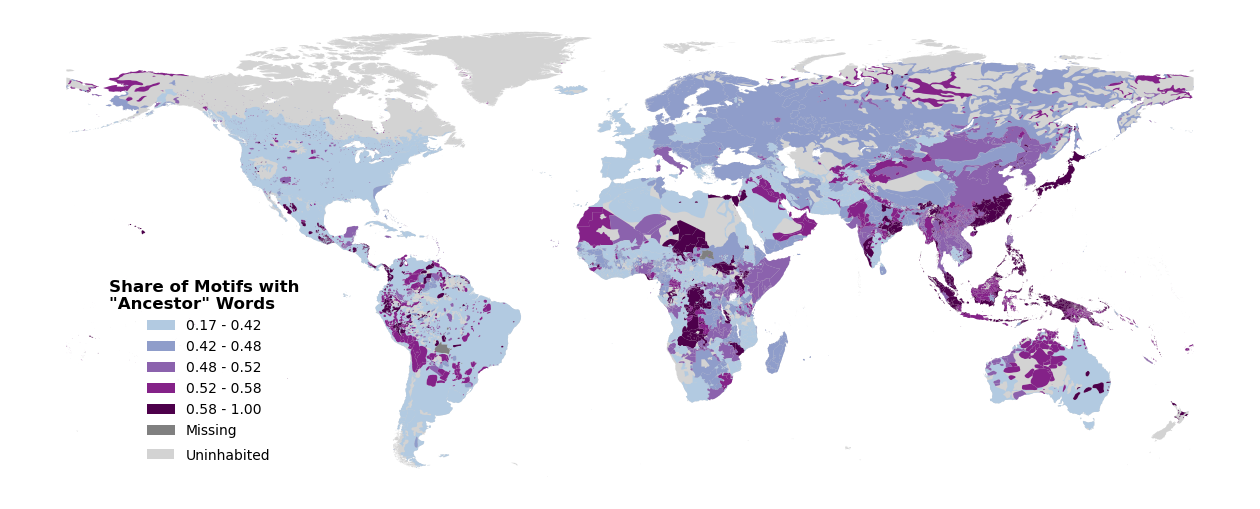

In [17]:
# Step 1: Extract unique categories (excluding NaNs)
categories = poscol_shape['quantile_cat'].dropna().unique()
categories = sorted(categories)  # Optional: sort for consistent coloring

# Step 2: Sample colors from the custom colormap
n = len(categories)
category_colors = strong_bupu(np.linspace(0, 1, n))
category_color_map = dict(zip(categories, category_colors))

# Step 3: Map the colors to a new column
poscol_shape['color'] = poscol_shape['quantile_cat'].map(category_color_map)

# Step 4: Plot
fig, ax = plt.subplots(1, 1, figsize=(16, 8), facecolor='white')

# Background
basemap_shape.plot(
    ax=ax,
    color='lightgray',
    edgecolor='black',
    linewidth=0
)

# Plot polygons with mapped colors
poscol_shape.plot(
    ax=ax,
    color=poscol_shape['color'].fillna('gray'),  # gray for NaNs
    edgecolor='none',
    linewidth=0
)

# Custom legend
legend_elements = [
    Patch(facecolor=category_color_map[c], label=label_map.get(c, str(c)))
    for c in categories
]

# Add missing/NaN explicitly if you want
legend_elements.append(Patch(facecolor='gray', label="Missing"))

# Show legend on the map
legend = ax.legend(
    handles=legend_elements,
    loc='lower left',
    bbox_to_anchor=(0.07, 0.1, 0.2, 0.2),
    frameon=False,
    title="Share of Motifs with\n\"Ancestor\" Words",
    title_fontproperties=FontProperties(weight='bold', size=12),
    prop=FontProperties(size=10)
)

# Create a rectangular legend patch
uninhabited_patch = Patch(
    facecolor='lightgray',
    edgecolor='none',
    label='Uninhabited'
)

# Add to the legend
custom_legend = ax.legend(
    handles=[uninhabited_patch],
    loc='lower left',
    bbox_to_anchor=(0.1, 0.05, 0.2, 0.2),
    frameon=False,
    prop = FontProperties(size=10),
)

# Add it to other legend
ax.add_artist(legend)

# Force same spatial extent
ax.set_aspect('equal', adjustable='box')
ax.set_axis_off()

# Save to PDF
plt.savefig(export_path / "Replication_AncestorSh_POSCOL.pdf", format='pdf', dpi=300, bbox_inches='tight')

#Show the plot
plt.show()

### -- Map 3: Class Stratification

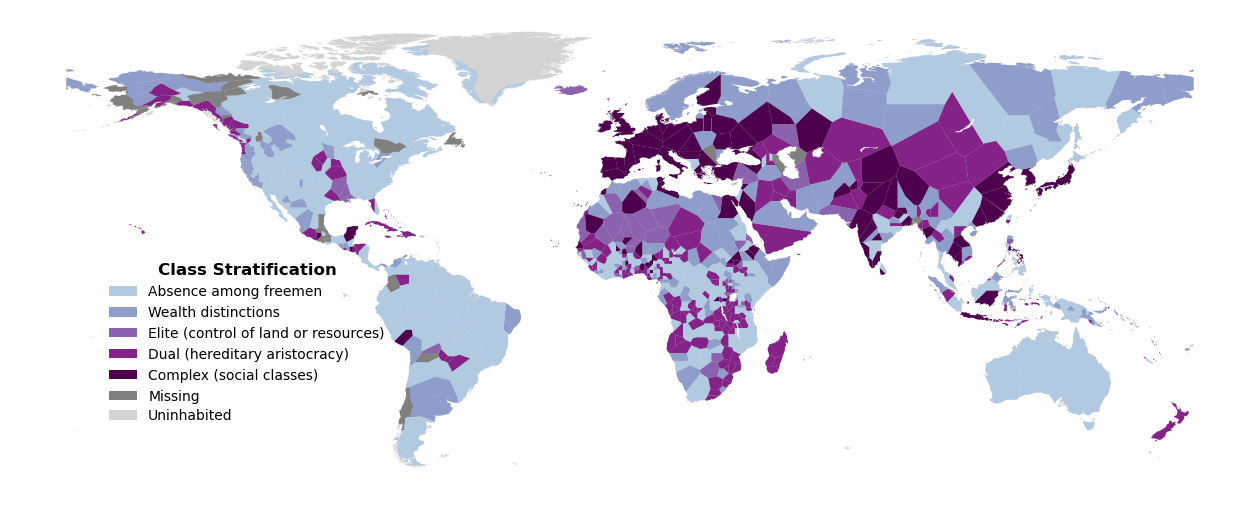

In [18]:
# Step 1: Extract unique categories (excluding NaNs)
categories = precol_shape['v66'].dropna().unique()
categories = sorted(categories)  # Optional: sort for consistent coloring

# Step 2: Sample colors from the custom colormap
n = len(categories)
category_colors = strong_bupu(np.linspace(0, 1, n))
category_color_map = dict(zip(categories, category_colors))

# Step 3: Map the colors to a new column
precol_shape['color'] = precol_shape['v66'].map(category_color_map)

# Step 4: Plot
fig, ax = plt.subplots(1, 1, figsize=(16, 8), facecolor='white')

# Background
basemap_shape.plot(
    ax=ax,
    color='lightgray',
    edgecolor='black',
    linewidth=0
)

# Plot polygons with mapped colors
precol_shape.plot(
    ax=ax,
    color=precol_shape['color'].fillna('gray'),  # gray for NaNs
    edgecolor='none',
    linewidth=0
)

# Dictionary for labels
label_map = {
    1: "Absence among freemen",
    2: "Wealth distinctions",
    3: "Elite (control of land or resources)",
    4: "Dual (hereditary aristocracy)",
    5: "Complex (social classes)"
}

# Custom legend
legend_elements = [
    Patch(facecolor=category_color_map[c], label=label_map.get(c, str(c)))
    for c in categories
]

# Add missing/NaN explicitly if you want
legend_elements.append(Patch(facecolor='gray', label="Missing"))

# Show legend on the map
legend = ax.legend(
    handles=legend_elements,
    loc='lower left',
    bbox_to_anchor=(0.07, 0.17, 0.2, 0.2),
    frameon=False,
    title="Class Stratification",
    title_fontproperties=FontProperties(weight='bold', size=12),
    prop=FontProperties(size=10)
)

# Create a rectangular legend patch
uninhabited_patch = Patch(
    facecolor='lightgray',
    edgecolor='none',
    label='Uninhabited'
)

# Add to the legend
custom_legend = ax.legend(
    handles=[uninhabited_patch],
    loc='lower left',
    bbox_to_anchor=(0.07, 0.13, 0.2, 0.2),
    frameon=False,
    prop = FontProperties(size=10),
)

# Add it to other legend
ax.add_artist(legend)

# Force same spatial extent
ax.set_aspect('equal', adjustable='box')
ax.set_axis_off()

# Save to PDF
plt.savefig(export_path / "Replication_ClassStrati_PRECOL.pdf", format='pdf', dpi=300, bbox_inches='tight')

#Show the plot
plt.show()

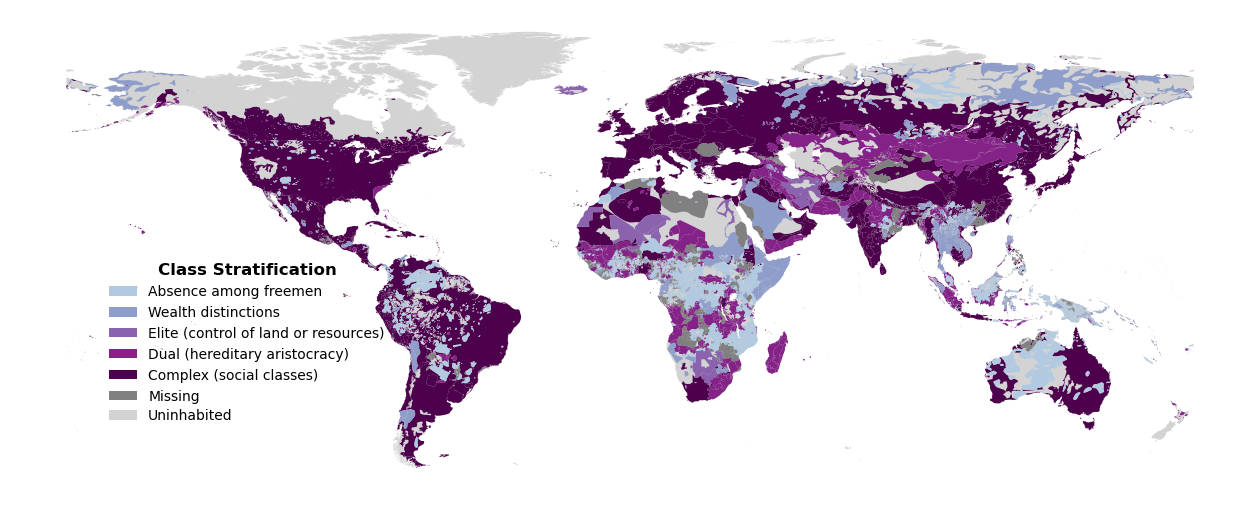

In [19]:
# Step 1: Extract unique categories (excluding NaNs)
categories = poscol_shape['v66'].dropna().unique()
categories = sorted(categories)  # Optional: sort for consistent coloring

# Step 2: Sample colors from the custom colormap
n = len(categories)
category_colors = strong_bupu(np.linspace(0, 1, n))
category_color_map = dict(zip(categories, category_colors))

# Step 3: Map the colors to a new column
poscol_shape['color'] = poscol_shape['v66'].map(category_color_map)

# Step 4: Plot
fig, ax = plt.subplots(1, 1, figsize=(16, 8), facecolor='white')

# Background
basemap_shape.plot(
    ax=ax,
    color='lightgray',
    edgecolor='black',
    linewidth=0
)

# Plot polygons with mapped colors
poscol_shape.plot(
    ax=ax,
    color=poscol_shape['color'].fillna('gray'),  # gray for NaNs
    edgecolor='none',
    linewidth=0
)

# Dictionary for labels
label_map = {
    1: "Absence among freemen",
    2: "Wealth distinctions",
    3: "Elite (control of land or resources)",
    4: "Dual (hereditary aristocracy)",
    5: "Complex (social classes)"
}

# Custom legend
legend_elements = [
    Patch(facecolor=category_color_map[c], label=label_map.get(c, str(c)))
    for c in categories
]

# Add missing/NaN explicitly if you want
legend_elements.append(Patch(facecolor='gray', label="Missing"))

# Show legend on the map
legend = ax.legend(
    handles=legend_elements,
    loc='lower left',
    bbox_to_anchor=(0.07, 0.17, 0.2, 0.2),
    frameon=False,
    title="Class Stratification",
    title_fontproperties=FontProperties(weight='bold', size=12),
    prop=FontProperties(size=10)
)

# Create a rectangular legend patch
uninhabited_patch = Patch(
    facecolor='lightgray',
    edgecolor='none',
    label='Uninhabited'
)

# Add to the legend
custom_legend = ax.legend(
    handles=[uninhabited_patch],
    loc='lower left',
    bbox_to_anchor=(0.07, 0.13, 0.2, 0.2),
    frameon=False,
    prop = FontProperties(size=10),
)

# Add it to other legend
ax.add_artist(legend)

# Force same spatial extent
ax.set_aspect('equal', adjustable='box')
ax.set_axis_off()

# Save to PDF
plt.savefig(export_path / "Replication_ClassStrati_POSCOL.pdf", format='pdf', dpi=300, bbox_inches='tight')

#Show the plot
plt.show()

# - Map 4: Nature has Agency 

In [20]:
# Define the number of quantiles
num_quantiles = 5

# Create quantile bins and get the labels
precol_shape['quantile_cat'], bins = pd.qcut(precol_shape['sh_nature_smotif_atleast_nonexcl'], q=num_quantiles, retbins=True, labels=False, duplicates='drop')

# Classifying with same bins
poscol_shape['quantile_cat'] = pd.cut(
    poscol_shape['sh_nature_smotif_atleast_nonexcl'],
    bins=bins,
    labels=False,
    include_lowest=True
)

#Creating the labels for the legend
label_map = {
    i: f"{bins[i]:.2f} - {bins[i+1]:.2f}"
    for i in range(len(bins) - 1)
}

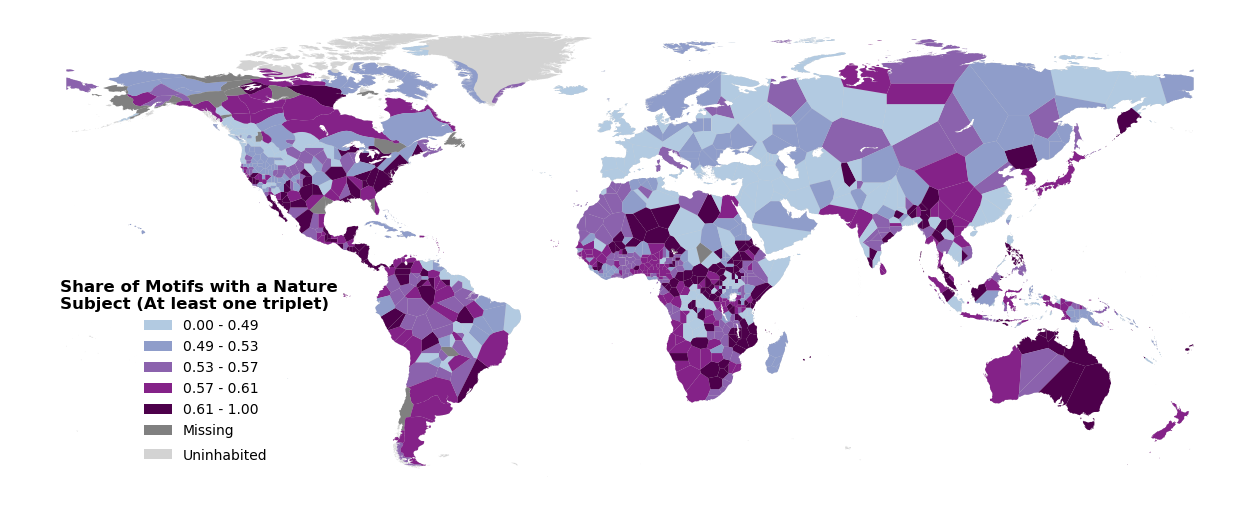

In [21]:
# Step 1: Extract unique categories (excluding NaNs)
categories = precol_shape['quantile_cat'].dropna().unique()
categories = sorted(categories)  # Optional: sort for consistent coloring

# Step 2: Sample colors from the custom colormap
n = len(categories)
category_colors = strong_bupu(np.linspace(0, 1, n))
category_color_map = dict(zip(categories, category_colors))

# Step 3: Map the colors to a new column
precol_shape['color'] = precol_shape['quantile_cat'].map(category_color_map)

# Step 4: Plot
fig, ax = plt.subplots(1, 1, figsize=(16, 8), facecolor='white')

# Background
basemap_shape.plot(
    ax=ax,
    color='lightgray',
    edgecolor='black',
    linewidth=0
)

# Plot polygons with mapped colors
precol_shape.plot(
    ax=ax,
    color=precol_shape['color'].fillna('gray'),  # gray for NaNs
    edgecolor='none',
    linewidth=0
)

# Custom legend
legend_elements = [
    Patch(facecolor=category_color_map[c], label=label_map.get(c, str(c)))
    for c in categories
]

# Add missing/NaN explicitly if you want
legend_elements.append(Patch(facecolor='gray', label="Missing"))

# Show legend on the map
legend = ax.legend(
    handles=legend_elements,
    loc='lower left',
    bbox_to_anchor=(0.03, 0.1, 0.2, 0.2),
    frameon=False,
    title="Share of Motifs with a Nature \nSubject (At least one triplet)",
    title_fontproperties=FontProperties(weight='bold', size=12),
    prop=FontProperties(size=10)
)

# Create a rectangular legend patch
uninhabited_patch = Patch(
    facecolor='lightgray',
    edgecolor='none',
    label='Uninhabited'
)

# Add to the legend
custom_legend = ax.legend(
    handles=[uninhabited_patch],
    loc='lower left',
    bbox_to_anchor=(0.098, 0.05, 0.2, 0.2),
    frameon=False,
    prop = FontProperties(size=10),
)

# Add it to other legend
ax.add_artist(legend)

# Force same spatial extent
ax.set_aspect('equal', adjustable='box')
ax.set_axis_off()

# Save to PDF
plt.savefig(export_path / "Replication_NatureSubject_PRECOL.pdf", format='pdf', dpi=300, bbox_inches='tight')

#Show the plot
plt.show()

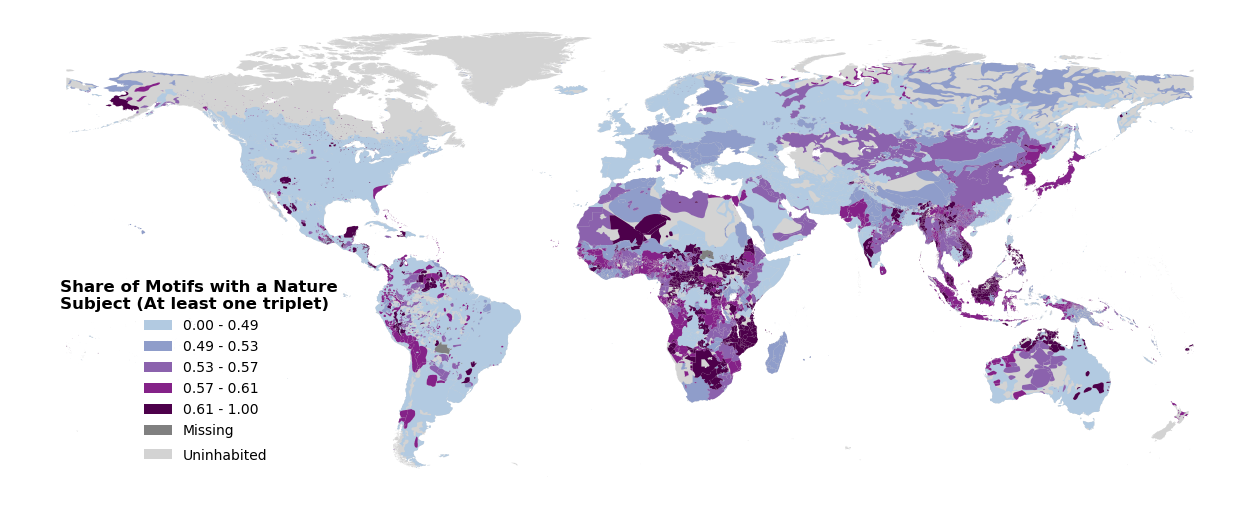

In [22]:
# Step 1: Extract unique categories (excluding NaNs)
categories = poscol_shape['quantile_cat'].dropna().unique()
categories = sorted(categories)  # Optional: sort for consistent coloring

# Step 2: Sample colors from the custom colormap
n = len(categories)
category_colors = strong_bupu(np.linspace(0, 1, n))
category_color_map = dict(zip(categories, category_colors))

# Step 3: Map the colors to a new column
poscol_shape['color'] = poscol_shape['quantile_cat'].map(category_color_map)

# Step 4: Plot
fig, ax = plt.subplots(1, 1, figsize=(16, 8), facecolor='white')

# Background
basemap_shape.plot(
    ax=ax,
    color='lightgray',
    edgecolor='black',
    linewidth=0
)

# Plot polygons with mapped colors
poscol_shape.plot(
    ax=ax,
    color=poscol_shape['color'].fillna('gray'),  # gray for NaNs
    edgecolor='none',
    linewidth=0
)

# Custom legend
legend_elements = [
    Patch(facecolor=category_color_map[c], label=label_map.get(c, str(c)))
    for c in categories
]

# Add missing/NaN explicitly if you want
legend_elements.append(Patch(facecolor='gray', label="Missing"))

# Show legend on the map
legend = ax.legend(
    handles=legend_elements,
    loc='lower left',
    bbox_to_anchor=(0.03, 0.1, 0.2, 0.2),
    frameon=False,
    title="Share of Motifs with a Nature \nSubject (At least one triplet)",
    title_fontproperties=FontProperties(weight='bold', size=12),
    prop=FontProperties(size=10)
)

# Create a rectangular legend patch
uninhabited_patch = Patch(
    facecolor='lightgray',
    edgecolor='none',
    label='Uninhabited'
)

# Add to the legend
custom_legend = ax.legend(
    handles=[uninhabited_patch],
    loc='lower left',
    bbox_to_anchor=(0.098, 0.05, 0.2, 0.2),
    frameon=False,
    prop = FontProperties(size=10),
)

# Add it to other legend
ax.add_artist(legend)

# Force same spatial extent
ax.set_aspect('equal', adjustable='box')
ax.set_axis_off()

# Save to PDF
plt.savefig(export_path / "Replication_NatureSubject_POSCOL.pdf", format='pdf', dpi=300, bbox_inches='tight')

#Show the plot
plt.show()